In [1]:
push!(LOAD_PATH,"../../src/");

In [2]:
using Yao, YaoDraw, Yao.AD, LinearAlgebra

# A function to round displayed results so they're easier to understand
rounded(x) = round(x;digits=3);

# Define the number of qubits to use
qubits = 3

3

## Define ansatz

This ansatz is circuit 2 from this [paper](http://arxiv.org/abs/1905.10876)

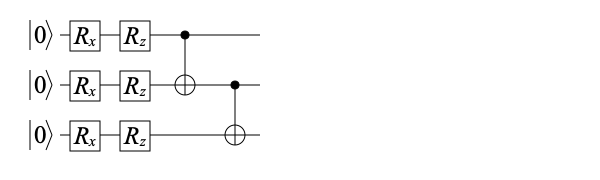

In [3]:
ansatz(n, θs) = chain(n, 
    chain(n, [put(i => Rx(θs[i])) for i in 1:n]),
    chain(n, [put(i => Rz(θs[i+n])) for i in 1:n]),
    chain(n, [control(i,i+1 => X) for i in 1:n-1]))

ansatz(θs) = ansatz(qubits, θs)

draw(ansatz(rand(2*qubits)))

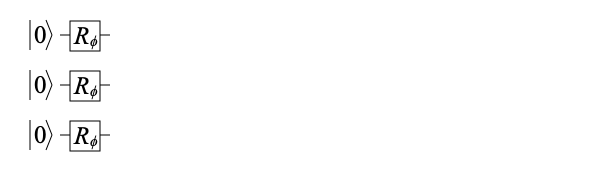

In [4]:
P(αs) = chain([ansatz(αs[:,i]) for i in 1:size(αs, 2)])
D(γs) = chain(qubits, [put(i=>shift(γs[i])) for i in 1:qubits])

draw(D(rand(qubits)))

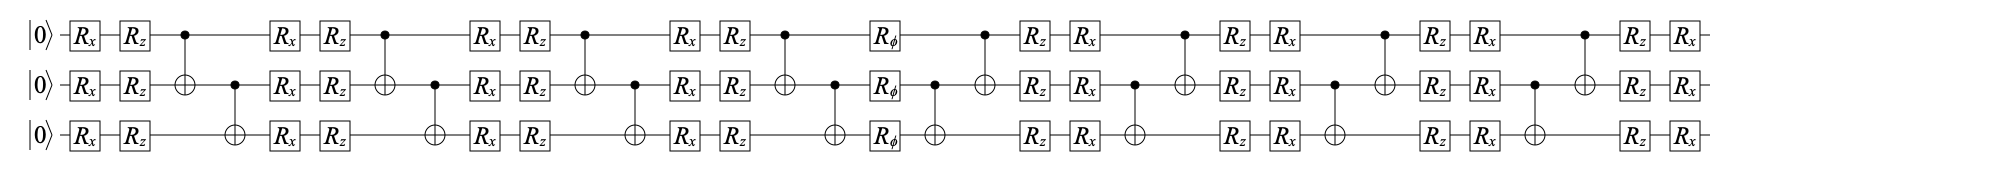

In [5]:
L = 4

function build_circuit(params; k=1)
    α = reshape(params[1:end-qubits], 2^qubits, L)
    γ = params[end-qubits+1:end]
    chain(P(α), D(γ*k), P(α)')
end

params = [reshape(rand(2^qubits, L), (2^qubits)*L); rand(qubits)]*2π
circuit = build_circuit(params)
draw(circuit, width=2000)

In [6]:
nparameters(circuit)

51

## Prepare the operation we want to emulate

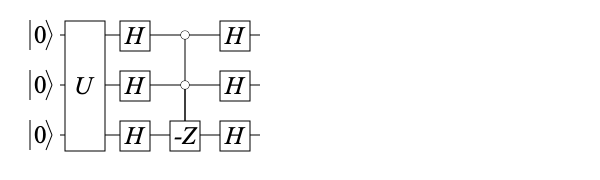

In [7]:
function oracle(u::T) where T<:Unsigned
    v = ones(ComplexF64, 1<<qubits)
    v[u+1] *= -1 # Flip the value we're looking for
    matblock(Diagonal(v))
end

O = oracle(0b01)

Hblock = repeat(qubits, H)
G = chain(Hblock, 
    control(qubits, -collect(1:qubits-1), qubits=>-Z), # I-2|0><0|
    Hblock)

M = chain(O, G)

@assert isunitary(M)

draw(M)

## Perform Evolutionary Optimisation

In [8]:
target = zero_state(qubits) |> Hblock |> M

function objective_function(params)
    out = zero_state(qubits) |> Hblock |> build_circuit(params)
    outδ = statevec(target) .- statevec(out)
    sum(abs.(outδ))
end

objective_function (generic function with 1 method)

In [9]:
initial_params = [reshape(rand(2^qubits, L), (2^qubits)*L); rand(qubits)]*2π;

In [10]:
using Evolutionary

res = Evolutionary.optimize(
            objective_function, 
            initial_params, 
            CMAES(μ=30, c_1=0.005),
            Evolutionary.Options(iterations=2000, abstol=0.00001, store_trace=true))


 * Status: success

 * Candidate solution
    Minimizer:  [-3.512473532600097, 2.3995573823554834, 1.6617726374537907,  ...]
    Minimum:    4.028392696677549e-5
    Iterations: 1417

 * Found with
    Algorithm: (30,60)-CMA-ES


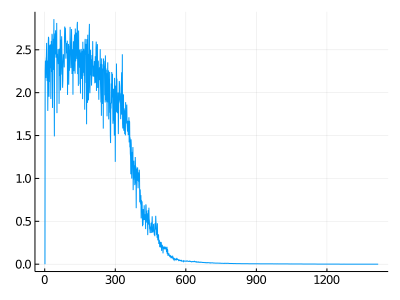

In [11]:
using Plots
trajectory = [t.value for t in Evolutionary.trace(res)]
plot(trajectory, size=(400,300), leg=:none)

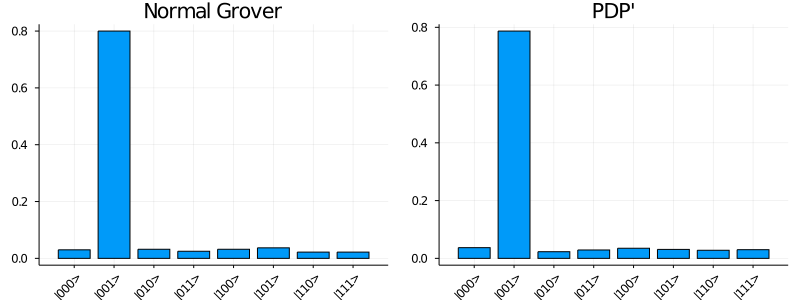

In [12]:
# Extract the parameters from the result
params = Evolutionary.minimizer(res)
α = reshape(params[1:end-qubits], 2^qubits, L)
γ = params[end-qubits+1:end]

# Setup the plots
run(circuit) = zero_state(qubits) |> Hblock |> chain(P(α), D(γ), P(α)') |> r -> measure(r, nshots=1000)
default(size=(800,300))

# Compare Grover with 
p1 = plot(M |> run, title="Normal Grover")
p2 = plot(chain(P(α), D(γ), P(α)') |> run, title="PDP'")
plot(p1, p2)

## Apply the circuit twice

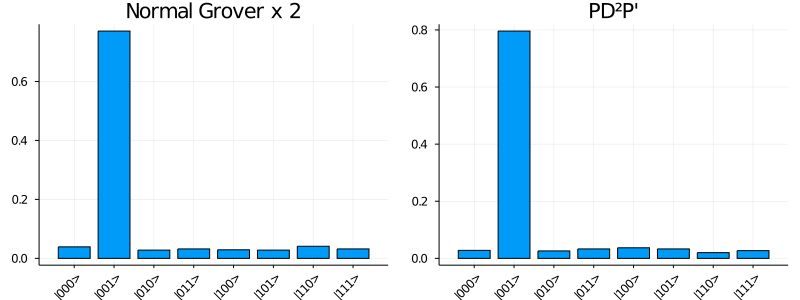

In [13]:
p1 = plot(chain(M,M) |> run, title="Normal Grover x 2")
p2 = plot(chain(P(α), D(γ*2), P(α)') |> run, title="PD²P'")
plot(p1, p2)

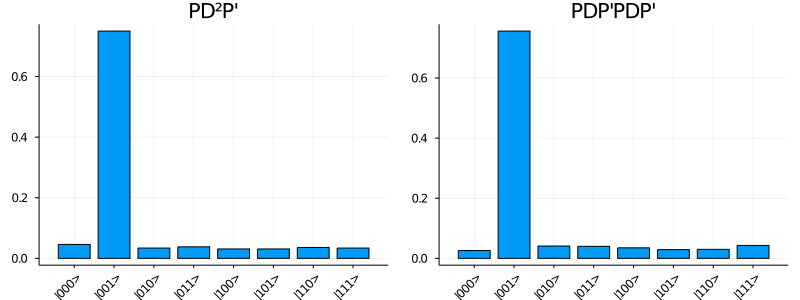

In [14]:
p1 = plot(chain(P(α), D(γ*2), P(α)') |> run, title="PD²P'")
p2 = plot(chain(P(α), D(γ), P(α)', P(α), D(γ), P(α)') |> run, title="PDP'PDP'")
plot(p1, p2)